# Homework 3 solutions

## Diffusion-limited aggregation

In [2]:
def remove_solids(coords, grid):
    # check to see if any of the walkers are next to a solid particle,
    # in which case mark that location as solid and remove the walker from the list
    for ind, (i,j) in enumerate(coords):
        if np.sum(grid[i-1:i+2, j-1:j+2])>0:
            grid[i,j] = 1
            coords[ind] = (-1,-1)
    ind = np.where(coords[:] != (-1,-1))
    coords = coords[ind]
    coords = np.reshape(coords,(int(len(coords)/2),2))
    return coords, grid

<Figure size 640x480 with 0 Axes>

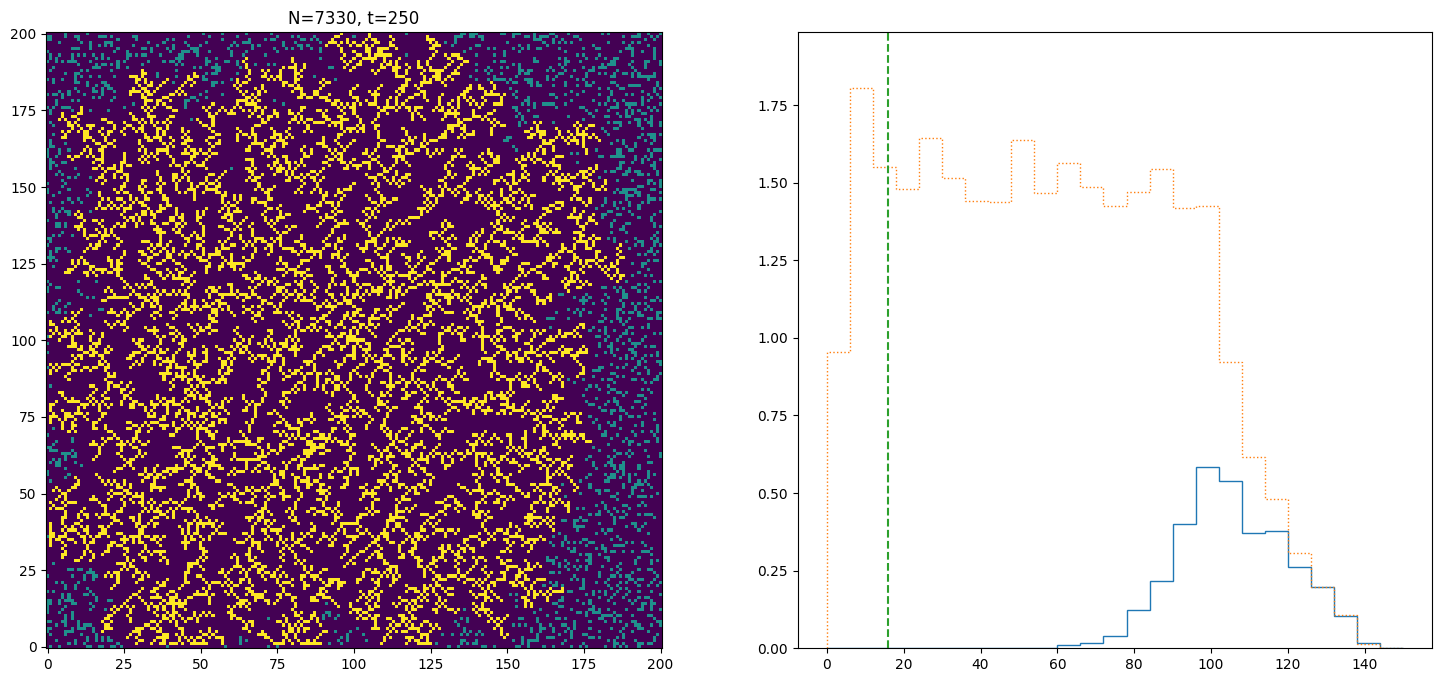

Time taken =  4.603363037109375


In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed = 12345)

ngrid = 201
ncenter = 100

grid = np.zeros((ngrid, ngrid))

# Set the initial "seed" at the center of the grid
#for i in range(ngrid):
#    for j in range(ngrid):
#        if ((i-ncenter)**2 + (j-ncenter)**2) < 3:
#            grid[i,j] = 1
# or start with only 1 particle in the center
grid[ncenter, ncenter] = 1

# An alternative is to try a linear seed:
#n1 = int(ngrid*0.49)
#n2 = int(ngrid*0.51)
#grid[n1:n2, n1:n2] = 1

# the number of "walkers" (=liquid particles)
nwalkers = 10000

# now assign random coordinates to the walkers
coords = rng.integers(low=0, high=ngrid, size=(nwalkers,2))
coords, grid = remove_solids(coords, grid)

# calculate the radial distances from the center for all particles
r_vec0 = np.zeros(len(coords[:]))
for ind, (i,j) in enumerate(coords):
    r_vec0[ind] = np.sqrt((i-ncenter)**2 + (j-ncenter)**2)

# store the number of solid particles vs time
n_arr = np.array([])
t_arr = np.array([])

t0 = time.time()

t = 0
fig_count = 0

# Keep going until we've used up some fraction of the walkers
while len(coords[:]) > 0.2 * nwalkers:

    coords = (coords + rng.integers(-1, high=2, size=np.shape(coords))) % ngrid
    coords, grid = remove_solids(coords, grid)

    if  t % 10 == 0:
        
        plt.close()
        plt.clf()
        
        fig = plt.figure(figsize=(18,8))
        ax1 = fig.add_subplot(121)
        ax1.set_title('N=%d, t=%d' % (np.sum(grid), t))
    
        gridw = np.zeros((ngrid, ngrid))
        for (i,j) in coords:
            gridw[i,j] = 1
        ax1.imshow(np.minimum(gridw + 2*grid,2), origin='lower', interpolation ='none')
        
        ax2 = fig.add_subplot(122)
        r_vec = np.zeros(len(coords[:]))
        for ind, (i,j) in enumerate(coords):
            r_vec[ind] = np.sqrt((i-ncenter)**2 + (j-ncenter)**2)
        bins0 = np.linspace(0,150,26)
        counts, bins = np.histogram(r_vec, bins = bins0)
        rads = 0.5*(bins[:-1] + bins[1:])
        plt.stairs(counts / (2*np.pi*rads), bins)
        counts, bins = np.histogram(r_vec0, bins = bins0)
        rads = 0.5*(bins[:-1] + bins[1:])
        plt.stairs(counts / (2*np.pi*rads), bins, linestyle=":")
        
        ymax = 1.1*max(counts/ (2*np.pi*rads))
        plt.plot([np.sqrt(t),np.sqrt(t)],[0.0,ymax], "--")
        plt.ylim((0.0,ymax))
        
        # Save the plot as a png file so we can make a movie
        #fig_count += 1
        #plt.savefig('figs/%0.4d.png' % (fig_count,))
        
        #plt.show()
    

    t = t + 1
    n_arr = np.append(n_arr, np.sum(grid))
    t_arr = np.append(t_arr, t)
    
plt.show()
print("Time taken = ", time.time()-t0)


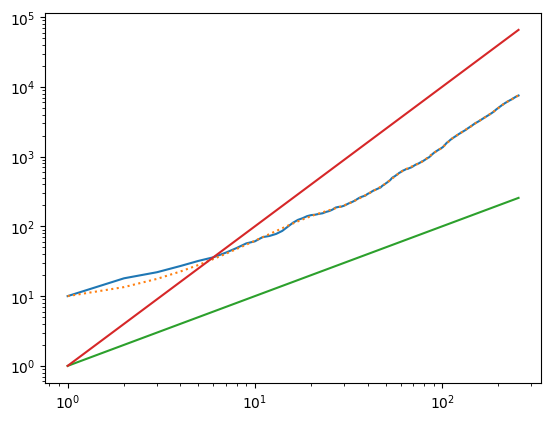

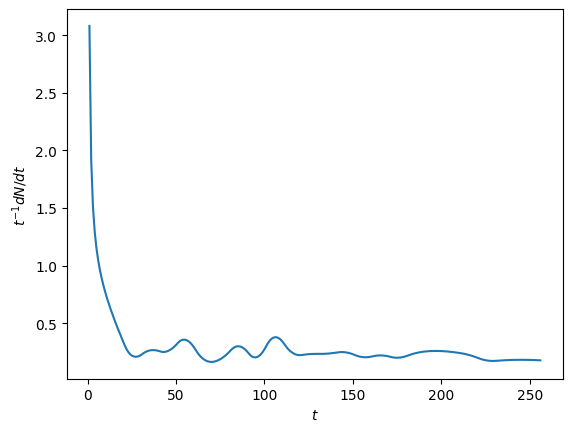

In [7]:
import scipy.interpolate

# Construct a spline of N(t)
spline = scipy.interpolate.CubicSpline(t_arr[::10],n_arr[::10])

# Plot N(t)
plt.plot(t_arr, n_arr)
plt.plot(t_arr, spline(t_arr), ":")
plt.yscale('log')
plt.xscale('log')
plt.plot(t_arr, t_arr)
plt.plot(t_arr, t_arr**2)
plt.show()

# Plot dN/dt  / t
plt.clf()
plt.plot(t_arr, spline(t_arr,1)/t_arr)
plt.xlabel(r'$t$')
plt.ylabel(r'$t^{-1} dN/dt$')
#plt.yscale('log')
#plt.xscale('log')
plt.show()

The growth of the crystal depends on the density of liquid particles. When the density is low (try running this for $N=2500$ instead of $N=10^4$), the growth is limited by the rate at which particles can diffuse to the crystallization front. The time when the crystal reaches radius $r$ is given by the diffusion time corresponding to that distance, ie.

$$N \propto r^2 \propto (\sqrt{t})^2\propto t$$

or 

$${dN\over dt} = \mathrm{constant}.$$

In the plot showing the particles, the green vertical line on the right hand side indicates the size corresponding to $\sqrt{t}$. You can see that for $N=10^4$ the growth is much faster than $\sqrt{t}$. What is happening is that the density is large enough that particles do not have to diffuse far to reach the solid. The growth is then proportional to the area available for particles to solidify onto

$${dN\over dt}\propto r\propto N^{1/2}\Rightarrow N^{1/2}\propto t\Rightarrow N\propto t^2$$

The $t^2$ scaling agrees well with the results (compare the red line), which can also be seen by the roughly constant value of $t^{-1} \dot{N}$ in the final plot.

## Ising model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

seed = 112345
rng = np.random.default_rng(seed)

In [5]:
def run_ising(beta):
    
    N = 30
    Nspins = N*N
    ntrials = 10**5

    # Populate the array with random spins (+1 or -1)
    #spins = -1 + rng.integers(2, size = Nspins) * 2
    spins = np.ones(Nspins)

    M = np.zeros(ntrials)
    M[0] = np.sum(spins)/Nspins  # starting point

    # Compute the random numbers to use for accepting the jump in advance
    u = rng.uniform(size=ntrials)
    
    for i in range(ntrials-1):
        
        # Choose spin at random
        j = rng.integers(Nspins)
    
        # Compute energy change if this spin were to flip
        delta_E = 2*spins[j] * (spins[j-1] + spins[(j+1) % Nspins] + spins[j-N] + spins[(j+N) % Nspins])
    
        # Attempt flip
        if u[i] <= np.exp(-beta*delta_E):
            spins[j] = -spins[j]

        # Store magnetization
        M[i+1] = np.sum(spins)/Nspins
        
    # remove the first 20% (burn in)
    return M[int(ntrials/5):]

T =  1.0
T =  1.5000000000000004
T =  2.000000000000001
T =  2.5000000000000013
T =  3.0000000000000018
T =  3.500000000000002
T =  4.000000000000003
time =  23.00921607017517


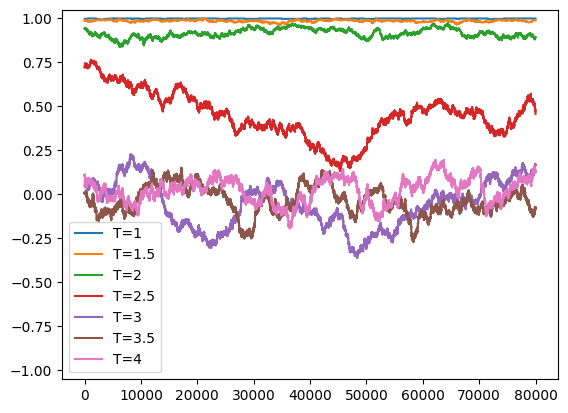

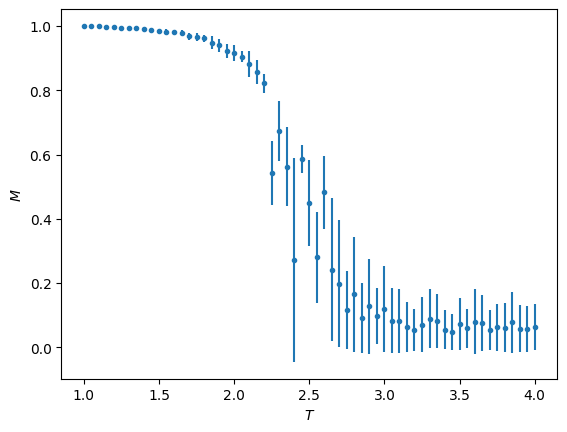

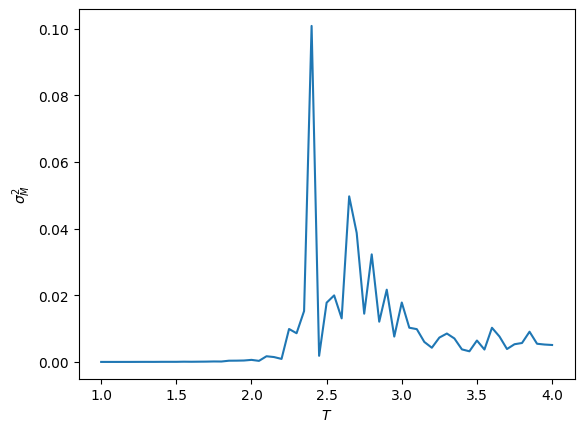

In [6]:
import time
t0 = time.time()

T_vals = np.arange(1.0,4.05,0.05)

M_vals = np.zeros_like(T_vals)
chi_vals = np.zeros_like(T_vals)

for i, T in enumerate(T_vals):
    M = run_ising(1/T)
    M_vals[i] = np.mean(np.abs(M))
    chi_vals[i] = np.var(M)

    if (abs(np.floor(T*2)-(T*2))<1e-5):
        print("T = ", T)
        t = np.arange(len(M))
        plt.plot(t, M, label = "T=%g" % (T,))

print('time = ', time.time()-t0)
        
plt.ylim((-1.05,1.05))
plt.legend()
plt.show()
        
plt.clf()
plt.errorbar(T_vals, M_vals, np.sqrt(chi_vals), fmt='.')
plt.ylabel(r'$M$')
plt.xlabel(r'$T$')
plt.show()

plt.clf()
plt.plot(T_vals, chi_vals)
plt.ylabel(r'$\sigma_M^2$')
plt.xlabel(r'$T$')
plt.show()